In [1]:
!unzip /kaggle/input/dataset1.zip -d /kaggle/working/

unzip:  cannot find or open /kaggle/input/dataset1.zip, /kaggle/input/dataset1.zip.zip or /kaggle/input/dataset1.zip.ZIP.


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Define the complete model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train the model with callbacks
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_resnet50_model.keras', save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss_fine_tune, test_acc_fine_tune = transfer_model.evaluate(test_generator)
print(f"Fine-tuned Transfer Learning Test Accuracy: {test_acc_fine_tune:.2f}")


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/55 ━━━━━━━━━━━━━━━━━━━━ 15:59 18s/step - accuracy: 0.2727 - loss: 9.4288

I0000 00:00:1719731749.777084     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719731749.829320     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 580ms/step - accuracy: 0.5251 - loss: 9.0033 - val_accuracy: 0.6053 - val_loss: 8.6605
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.5271 - loss: 8.7499 - val_accuracy: 0.6053 - val_loss: 8.4376
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.5248 - loss: 8.5271 - val_accuracy: 0.5973 - val_loss: 8.2304
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.5176 - loss: 8.3139 - val_accuracy: 0.5947 - val_loss: 8.0284
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.5130 - loss: 8.1063 - val_accuracy: 0.5840 - val_loss: 7.8349
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.5089 - loss: 7.9072 - val_accuracy: 0.5680 - val_loss: 7.6462
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.5331 - loss: 7.7267 - val_accuracy: 0.5680 - val_loss: 7.4625
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.5157 - loss: 7.5459 - val_accuracy: 0.589

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train the model with callbacks
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_densenet_model.keras', save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss_fine_tune, test_acc_fine_tune = transfer_model.evaluate(test_generator)
print(f"Fine-tuned DenseNet121 Test Accuracy: {test_acc_fine_tune:.2f}")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5429 - loss: 1.5174 - val_accuracy: 0.6427 - val_loss: 1.2332
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step - accuracy: 0.5802 - loss: 1.4330 - val_accuracy: 0.6267 - val_loss: 1.1773
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.6014 - loss: 1.3164 - val_accuracy: 0.6693 - val_loss: 1.0896
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.5924 - loss: 1.2693 - val_accuracy: 0.6933 - val_loss: 1.0506
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.6272 - loss: 1.2029 - val_accuracy: 0.6960 - val_loss: 1.0127
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.6397 - loss: 1.1568 - val_accuracy: 0.6987 - val_loss: 0.9845
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.6386 - loss: 1.1347 - val_accuracy: 0.7147 - val_loss: 0.9534
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/s

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,  # Adjusted to 20%
    height_shift_range=0.2,  # Adjusted to 20%
    shear_range=0.2,  # Adjusted to 20%
    zoom_range=0.2,  # Adjusted to 20%
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Load the best checkpointed model (if available)
checkpoint_path = 'best_densenet_model.keras'
if os.path.exists(checkpoint_path):
    transfer_model = tf.keras.models.load_model(checkpoint_path)
    print(f"Loaded checkpointed model from {checkpoint_path}")
else:
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the complete model
    transfer_model = Model(inputs=base_model.input, outputs=predictions)

    print("Created a new DenseNet121 model.")

# Compile the model (if not loaded from checkpoint)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train the model with callbacks
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=30,  # Adjust epochs as needed
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss_fine_tune, test_acc_fine_tune = transfer_model.evaluate(test_generator)
print(f"Fine-tuned DenseNet121 Test Accuracy: {test_acc_fine_tune:.2f}")


Loaded checkpointed model from best_densenet_model.keras
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 707ms/step - accuracy: 0.7704 - loss: 0.8053 - val_accuracy: 0.7787 - val_loss: 0.7336
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.7447 - loss: 0.7775 - val_accuracy: 0.7333 - val_loss: 0.7683
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.7124 - loss: 0.8321 - val_accuracy: 0.7573 - val_loss: 0.7430
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.7571 - loss: 0.7842 - val_accuracy: 0.7760 - val_loss: 0.7064
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.7621 - loss: 0.7348 - val_accuracy: 0.7680 - val_loss: 0.7055
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.7360 - loss: 0.7899 - val_accuracy: 0.7493 - val_loss: 0.7209
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.7576 - loss: 0.7237 - val_accuracy: 0.7280 - val_loss: 0.7528
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18

EfficientNetB0

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train the model with callbacks
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_efficientnet_model.keras', save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss_fine_tune, test_acc_fine_tune = transfer_model.evaluate(test_generator)
print(f"Fine-tuned EfficientNetB0 Test Accuracy: {test_acc_fine_tune:.2f}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 977ms/step - accuracy: 0.5327 - loss: 1.4301 - val_accuracy: 0.6053 - val_loss: 1.3571
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.5275 - loss: 1.3610 - val_accuracy: 0.6053 - val_loss: 1.3002
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.5731 - loss: 1.3110 - val_accuracy: 0.6053 - val_loss: 1.2635
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.5708 - loss: 1.2816 - val_accuracy: 0.6053 - val_loss: 1.2259
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.5964 - loss: 1.2369 - val_accuracy: 0.6053 - val_loss: 1.1966
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.6027 - loss: 1.1986 - val_accuracy: 0.6053 - val_loss: 1.1729
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.6335 - loss: 1.1624 - val_accuracy: 0.6053 - val_loss: 1.1537
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 290m

Dense Net121

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,  # Adjusted to 20%
    height_shift_range=0.2,  # Adjusted to 20%
    shear_range=0.2,  # Adjusted to 20%
    zoom_range=0.2,  # Adjusted to 20%
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Load the best checkpointed model (if available) or create a new one
checkpoint_path = 'best_densenet_model.keras'
if os.path.exists(checkpoint_path):
    transfer_model = tf.keras.models.load_model(checkpoint_path)
    print(f"Loaded checkpointed model from {checkpoint_path}")
else:
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the complete model
    transfer_model = Model(inputs=base_model.input, outputs=predictions)

    print("Created a new DenseNet121 model.")

# Fine-tune layers by unfreezing some blocks
for layer in transfer_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Compile the model (if not loaded from checkpoint)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train the model with callbacks
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=30,  # Adjust epochs as needed
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss_fine_tune, test_acc_fine_tune = transfer_model.evaluate(test_generator)
print(f"Fine-tuned DenseNet121 Test Accuracy: {test_acc_fine_tune:.2f}")


Loaded checkpointed model from best_densenet_model.keras
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 769ms/step - accuracy: 0.7793 - loss: 0.6579 - val_accuracy: 0.7867 - val_loss: 0.6379
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.8104 - loss: 0.6307 - val_accuracy: 0.7733 - val_loss: 0.6412
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.7953 - loss: 0.6543 - val_accuracy: 0.7920 - val_loss: 0.6398
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.7896 - loss: 0.6443 - val_accuracy: 0.7920 - val_loss: 0.6309
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.8063 - loss: 0.6320 - val_accuracy: 0.7973 - val_loss: 0.6307
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.7775 - loss: 0.6725 - val_accuracy: 0.7840 - val_loss: 0.6416
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.7922 - loss: 0.6670 - val_accuracy: 0.7813 - val_loss: 0.6404
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18

NEW SESSION PART

In [19]:
import os
import numpy as np
import cv2  # Import OpenCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the path to the dataset (adjust based on your Kaggle environment)
data_dir = '/kaggle/input/dataset1/Brain_Data_Organised/'
normal_dir = os.path.join(data_dir, 'Normal')
stroke_dir = os.path.join(data_dir, 'Stroke')

# Parameters
img_size = (224, 224)
batch_size = 32

# Function to load images and labels using OpenCV
def load_data(dir, label):
    data = []
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        data.append((img, label))
    return data

# Load data
normal_data = load_data(normal_dir, 0)
stroke_data = load_data(stroke_dir, 1)

# Combine and split data
all_data = normal_data + stroke_data
images, labels = zip(*all_data)
images = np.array(images)
labels = np.array(labels)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,  # Adjusted to 20%
    height_shift_range=0.2,  # Adjusted to 20%
    shear_range=0.2,  # Adjusted to 20%
    zoom_range=0.2,  # Adjusted to 20%
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8243 - loss: 0.5912
Fine-tuned DenseNet121 Test Accuracy: 0.82
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 990ms/step
Confusion Matrix:
[[213  23]
 [ 45  95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       236
           1       0.81      0.68      0.74       140

    accuracy                           0.82       376
   macro avg       0.82      0.79      0.80       376
weighted avg       0.82      0.82      0.82       376


ROC AUC: 0.89


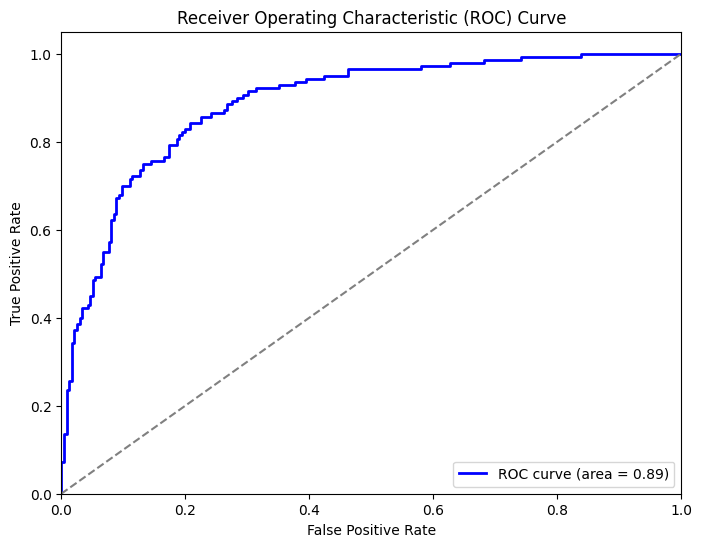

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# Evaluate the fine-tuned model on the test set
model = load_model('/kaggle/input/model1/best_densenet_model.keras')
test_loss_fine_tune, test_acc_fine_tune = model.evaluate(test_generator)
print(f"Fine-tuned DenseNet121 Test Accuracy: {test_acc_fine_tune:.2f}")

# Predict probabilities for the test set
y_pred_prob = model.predict(test_generator).ravel()

# Predict classes for the test set
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute metrics
cm = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Display metrics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)
print(f"\nROC AUC: {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


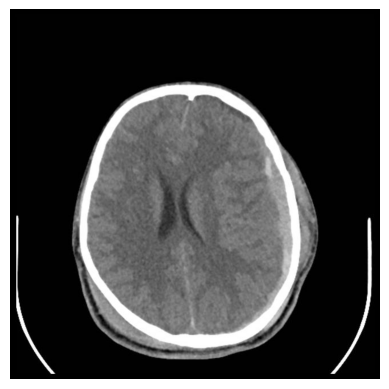

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: 0.90 - Classified as: Stroke


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Path to the dataset
dataset_path ='/kaggle/input/dataset1/Brain_Data_Organised/Stroke' # Adjust with your dataset name

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Select a random image
random_image_path = os.path.join(dataset_path, np.random.choice(os.listdir(dataset_path)))
test_image = preprocess_image(random_image_path)

# Display the image
plt.imshow(image.load_img(random_image_path))
plt.axis('off')
plt.show()

# Load your trained model
model = load_model('/kaggle/input/model1/best_densenet_model.keras')  # Adjust with your model path

# Predict on the test image
prediction = model.predict(test_image)
classification = 'Stroke' if prediction > 0.5 else 'Normal'
# Print prediction
print(f"Prediction: {prediction[0][0]:.2f} - Classified as: {classification}")


In [20]:
import pickle

In [21]:
pickle.dump(model,open('densemodel.pkl','wb'))

In [22]:
pickled_model=pickle.load(open('densemodel.pkl','rb'))

In [24]:
pickled_model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


array([[0.9021404]], dtype=float32)